

* **  IMPORT LIBS**



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from math import sin, cos, pi
from tqdm.notebook import tqdm

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from glob import glob

from PIL import Image
import imageio

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')



**READ DATA**

In [ ]:
# set paths to train and test image datasets
TRAIN_PATH = '/content/sample_data/train/'
TEST_PATH = '/content/sample_data/test/'


files = sorted(os.listdir(TRAIN_PATH))
images = [x for x in files]

train = pd.DataFrame()
train['images']= images
l=[]
m=[]
for i in images:
  l.append(i.split('.')[0])
  m.append(i.split('.')[0])


train['label'] = l


train.head()

,images,label
0,10C.png,10C
1,10D.png,10D
2,10H.png,10H
3,10S.png,10S
4,2D.png,2D


In [ ]:
tr=[]
t=[]
def tr_data():
  for img in sorted(os.listdir(TRAIN_PATH)):
    imgarr = cv2.imread(os.path.join(TRAIN_PATH,img), cv2.IMREAD_GRAYSCALE)
    new=cv2.resize(imgarr,(85,85))
    tr.append([new])
    t.append([new])

tr_data()



In [ ]:
tr = np.reshape(tr,(52, 85,85, 1))
t = np.reshape(t,(52, 85,85, 1))


In [ ]:
def plot_sample1(image,axis,title):
    image = image.reshape(85,85)
    axis.imshow(image)
    plt.title(title)

**IMAGES OF TRAIN DATA**

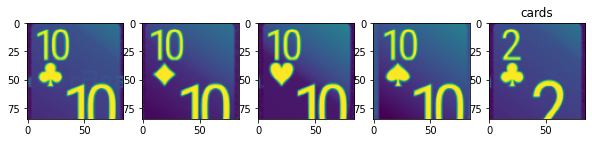

In [ ]:
fig, axis = plt.subplots(1,5,figsize=(10,20))
for l in range(5):
  plot_sample1(tr[l],axis[l],"cards") 


In [ ]:
horizontal_flip = True
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True


rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 80
BATCH_SIZE = 32

**CREATING NEW '''HORIZANTALLY FLIPPED DATA'''**

Shape of flipped_train_images: (52, 85, 85, 1)


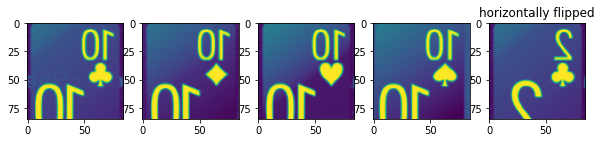

In [ ]:
def left_right_flip(images):
    flipped_images = np.flip(images , axis=2)   # Flip column-wise (axis=2)
    return flipped_images

if horizontal_flip:
    flipped_train_images = left_right_flip(t)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
#    train_images = np.concatenate((train_images, flipped_train_images))

np.reshape(flipped_train_images,(52, 85,85, 1))
tr = np.concatenate((tr,flipped_train_images))

tr.shape
fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(flipped_train_images[l],axis[l],"horizontally flipped") 



In [ ]:
train.drop(['images'],axis=1,inplace=True)
lab = train['label']
train=pd.concat([train]*42, ignore_index=True)
len(train['label'])

2184

In [ ]:
train.tail()

,label
2179,KS
2180,QC
2181,QD
2182,QH
2183,QS


In [ ]:
tr.shape

(104, 85, 85, 1)

**NEW ROTATED DATA**

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (104, 85, 85, 1)


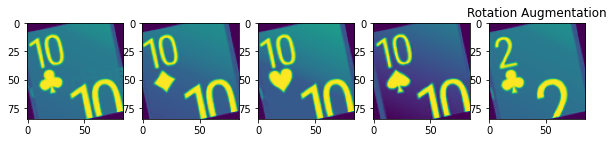

In [ ]:
def rotate_augmentation(images):
    rotated_images = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (85,85), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
           
            
    return np.reshape(rotated_images,(-1,85,85,1))

if rotation_augmentation:
    rotated_train_images = rotate_augmentation(t)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))

    
tr = np.concatenate((tr,rotated_train_images))
tr.shape  
rotated_train_images.shape
fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(rotated_train_images[l], axis[l], "Rotation Augmentation")
    

**NEW DATA WITH ADDED BRIGHTNESS**

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (104, 85, 85, 1)


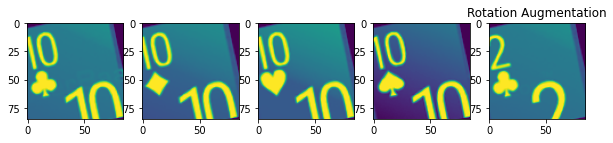

In [ ]:
def rotate_augmentation2(images):
    rotated_images = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((60,60), angle, 1.1)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (85,85), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
           
            
    return np.reshape(rotated_images,(-1,85,85,1))

if rotation_augmentation:
    rotated_train_images2 = rotate_augmentation2(t)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images2)))
    


tr = np.concatenate((tr,rotated_train_images2))
tr.shape  
rotated_train_images2.shape

fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(rotated_train_images2[l], axis[l], "Rotation Augmentation")
    

In [ ]:
def left_right_flip2(images):
    flipped_images = np.flip(images , axis=1)   # Flip column-wise (axis=2)
    return flipped_images

if horizontal_flip:
    flipped_train_images2 = left_right_flip2(t)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images2)))
#    train_images = np.concatenate((train_images, flipped_train_images))

Shape of flipped_train_images: (52, 85, 85, 1)


In [ ]:
np.reshape(flipped_train_images2,(52, 85,85, 1))


array([[[[73],
         [69],
         [67],
         ...,
         [74],
         [71],
         [65]],

        [[66],
         [66],
         [67],
         ...,
         [74],
         [66],
         [67]],

        [[67],
         [70],
         [69],
         ...,
         [74],
         [67],
         [65]],

        ...,

        [[69],
         [62],
         [63],
         ...,
         [71],
         [73],
         [69]],

        [[74],
         [71],
         [71],
         ...,
         [71],
         [76],
         [71]],

        [[64],
         [73],
         [73],
         ...,
         [70],
         [67],
         [69]]],


       [[[68],
         [70],
         [57],
         ...,
         [71],
         [74],
         [72]],

        [[75],
         [73],
         [60],
         ...,
         [68],
         [72],
         [74]],

        [[71],
         [72],
         [62],
         ...,
         [66],
         [69],
         [71]],

        ...,

        [[71],
 

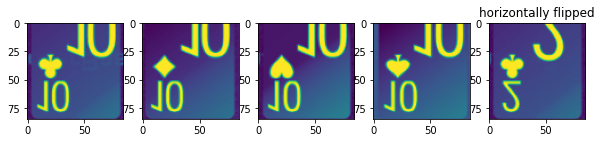

In [ ]:
tr = np.concatenate((tr,flipped_train_images))
fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(flipped_train_images2[l],axis[l],"horizontally flipped") 



Shape of altered_brightness_train_images: (104, 85, 85, 1)


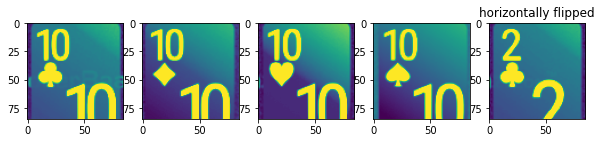

In [ ]:
def alter_brightness(images):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*0.006, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.006, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images

if brightness_augmentation:
    altered_brightness_train_images= alter_brightness(t)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")

tr = np.concatenate((tr,altered_brightness_train_images))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(altered_brightness_train_images[l],axis[l],"horizontally flipped") 

Shape of altered_brightness_train_images: (104, 85, 85, 1)


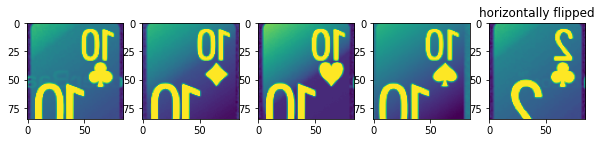

In [ ]:
if brightness_augmentation:
    altered_brightness_train_images2= alter_brightness(flipped_train_images)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")

tr = np.concatenate((tr,altered_brightness_train_images2))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(altered_brightness_train_images2[l],axis[l],"horizontally flipped")

Shape of altered_brightness_train_images: (104, 85, 85, 1)


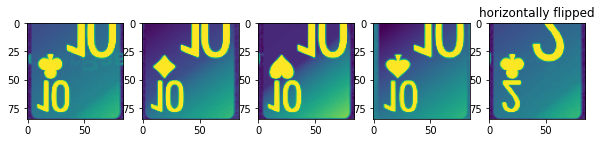

In [ ]:
if brightness_augmentation:
    altered_brightness_train_images3= alter_brightness(flipped_train_images2)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")

tr = np.concatenate((tr,altered_brightness_train_images3))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(altered_brightness_train_images3[l],axis[l],"horizontally flipped")

Shape of altered_brightness_train_images: (104, 85, 85, 1)


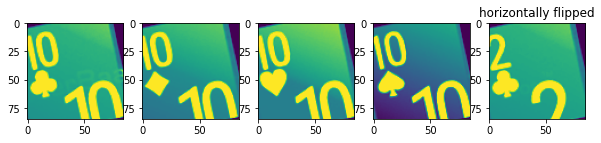

In [ ]:
if brightness_augmentation:
    altered_brightness_train_images4= alter_brightness(rotated_train_images2)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")

tr = np.concatenate((tr,altered_brightness_train_images4))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(altered_brightness_train_images4[l],axis[l],"horizontally flipped")

Shape of altered_brightness_train_images: (104, 85, 85, 1)


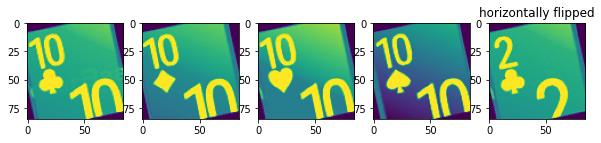

In [ ]:
if brightness_augmentation:
    altered_brightness_train_images5= alter_brightness(rotated_train_images)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")

tr = np.concatenate((tr,altered_brightness_train_images5))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(altered_brightness_train_images5[l],axis[l],"horizontally flipped")

In [ ]:
tr.shape

(1092, 85, 85, 1)

**NEW DATA WITH ADDED NOISE**

Shape of noisy_train_images: (52, 85, 85, 1)


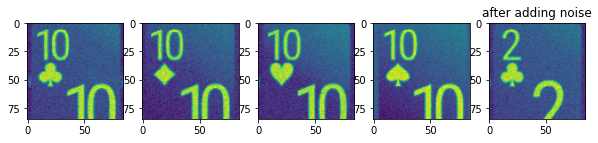

In [ ]:
def add_noise(images):
    noisy_images = []
    for image in images:
        image = np.asarray(image, np.float64)
        noisy_image = cv2.add(image, 9.8*(np.random.randn(85,85,1)))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(85,85,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(t)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")


tr = np.concatenate((tr,noisy_train_images))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images[l],axis[l],"after adding noise")

Shape of noisy_train_images: (52, 85, 85, 1)


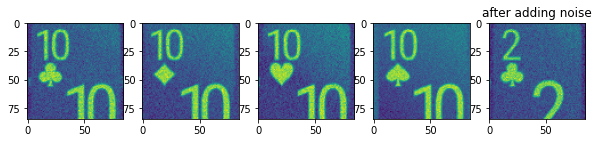

In [ ]:
def add_noise2(images):
    noisy_images = []
    for image in images:
        image = np.asarray(image, np.float64)
        noisy_image = cv2.add(image, 15.8*(np.random.randn(85,85,1)))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(85,85,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images2 = add_noise2(t)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images2)}")


tr = np.concatenate((tr,noisy_train_images2))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images2[l],axis[l],"after adding noise")

Shape of noisy_train_images3: (52, 85, 85, 1)


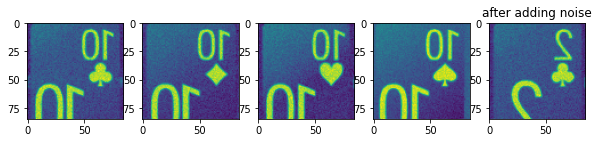

In [ ]:

if random_noise_augmentation:
    noisy_train_images3 = add_noise(flipped_train_images)
    print(f"Shape of noisy_train_images3: {np.shape(noisy_train_images3)}")


tr = np.concatenate((tr,noisy_train_images3))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images3[l],axis[l],"after adding noise")

Shape of noisy_train_images4: (52, 85, 85, 1)


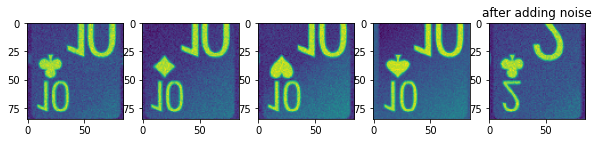

In [ ]:

if random_noise_augmentation:
    noisy_train_images4 = add_noise(flipped_train_images2)
    print(f"Shape of noisy_train_images4: {np.shape(noisy_train_images4)}")


tr = np.concatenate((tr,noisy_train_images4))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images4[l],axis[l],"after adding noise")

Shape of noisy_train_images5: (52, 85, 85, 1)


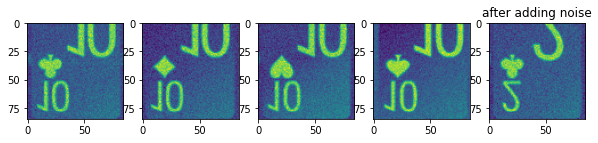

In [ ]:

if random_noise_augmentation:
    noisy_train_images5 = add_noise2(flipped_train_images2)
    print(f"Shape of noisy_train_images5: {np.shape(noisy_train_images5)}")


tr = np.concatenate((tr,noisy_train_images5))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images5[l],axis[l],"after adding noise")

Shape of noisy_train_images: (52, 85, 85, 1)


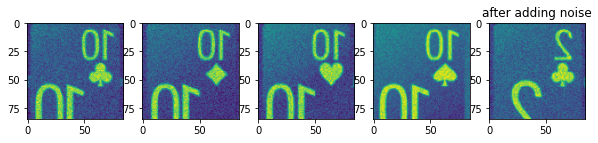

In [ ]:

if random_noise_augmentation:
    noisy_train_images6 = add_noise2(flipped_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images6)}")


tr = np.concatenate((tr,noisy_train_images6))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images6[l],axis[l],"after adding noise")

Shape of noisy_train_images7: (104, 85, 85, 1)


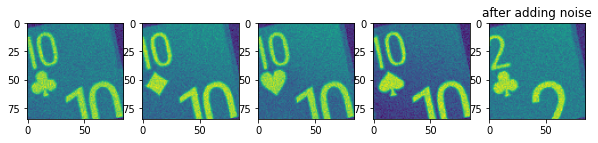

In [ ]:

if random_noise_augmentation:
    noisy_train_images7 = add_noise2(rotated_train_images2)
    print(f"Shape of noisy_train_images7: {np.shape(noisy_train_images7)}")


tr = np.concatenate((tr,noisy_train_images7))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images7[l],axis[l],"after adding noise")

Shape of noisy_train_images8: (104, 85, 85, 1)


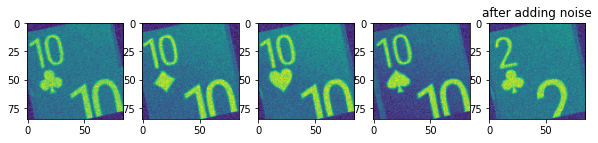

In [ ]:

if random_noise_augmentation:
    noisy_train_images8 = add_noise2(rotated_train_images)
    print(f"Shape of noisy_train_images8: {np.shape(noisy_train_images8)}")


tr = np.concatenate((tr,noisy_train_images8))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images8[l],axis[l],"after adding noise")

Shape of noisy_train_images9: (104, 85, 85, 1)


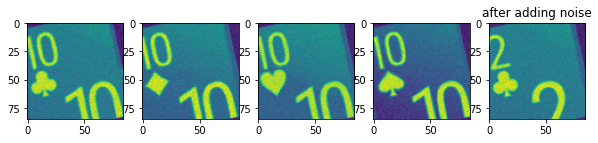

In [ ]:

if random_noise_augmentation:
    noisy_train_images9 = add_noise(rotated_train_images2)
    print(f"Shape of noisy_train_images9: {np.shape(noisy_train_images9)}")


tr = np.concatenate((tr,noisy_train_images9))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images9[l],axis[l],"after adding noise")

Shape of noisy_train_images10: (104, 85, 85, 1)


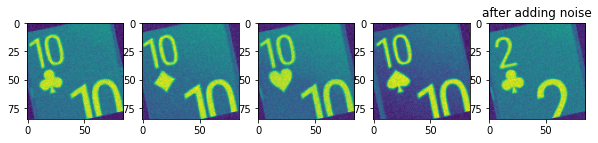

In [ ]:

if random_noise_augmentation:
    noisy_train_images10 = add_noise(rotated_train_images)
    print(f"Shape of noisy_train_images10: {np.shape(noisy_train_images10)}")


tr = np.concatenate((tr,noisy_train_images10))


fig, axis = plt.subplots(1,5,figsize=(10,30))
for l in range(5):
  plot_sample1(noisy_train_images10[l],axis[l],"after adding noise")

In [ ]:
def add_noise3(images):
    noisy_images = []
    for image in images:
        image = np.asarray(image, np.float64)
        noisy_image = cv2.add(image, 5.0*(np.random.randn(85,85,1)))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(85,85,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images11 = add_noise3(t)
if random_noise_augmentation:
    noisy_train_images12 = add_noise3(flipped_train_images)
if random_noise_augmentation:
    noisy_train_images13 = add_noise3(flipped_train_images2)
if random_noise_augmentation:
    noisy_train_images14 = add_noise3(rotated_train_images)
if random_noise_augmentation:
    noisy_train_images15 = add_noise3(rotated_train_images)

tr = np.concatenate((tr,noisy_train_images11))
tr = np.concatenate((tr,noisy_train_images12))
tr = np.concatenate((tr,noisy_train_images13))
tr = np.concatenate((tr,noisy_train_images14))
tr = np.concatenate((tr,noisy_train_images15))




In [ ]:
tr.shape

(2184, 85, 85, 1)

*PREPARING TRAINING AND VALIDATION DATA*

In [ ]:
train['im'] = [list() for x in range(2184)]
for i in range(2184):
  train.iloc[i,1]=tr[i].reshape(85*85)
train

,label,im
0,10C,"[64.0, 73.0, 73.0, 66.0, 68.0, 69.0, 71.0, 80...."
1,10D,"[71.0, 71.0, 71.0, 67.0, 61.0, 66.0, 72.0, 81...."
2,10H,"[72.0, 66.0, 66.0, 69.0, 72.0, 65.0, 65.0, 76...."
3,10S,"[72.0, 72.0, 74.0, 75.0, 73.0, 74.0, 71.0, 69...."
4,2C,"[72.0, 66.0, 66.0, 69.0, 70.0, 64.0, 67.0, 79...."
...,...,...
2179,KS,"[1.2606885334073397, 1.3502462769495125, -7.21..."
2180,QC,"[5.821510144426897, -3.1040372362365964, 2.619..."
2181,QD,"[-0.025672578069409216, 5.377885573404142, 2.7..."
2182,QH,"[-1.4173608332091243, -4.906854139873227, 6.69..."


In [ ]:
train['label'].unique()

array(['10C', '10D', '10H', '10S', '2C', '2D', '2H', '2S', '3C', '3D',
       '3H', '3S', '4C', '4D', '4H', '4S', '5C', '5D', '5H', '5S', '6C',
       '6D', '6H', '6S', '7C', '7D', '7H', '7S', '8C', '8D', '8H', '8S',
       '9C', '9D', '9H', '9S', 'AC', 'AD', 'AH', 'AS', 'JC', 'JD', 'JH',
       'JS', 'KC', 'KD', 'KH', 'KS', 'QC', 'QD', 'QH', 'QS'], dtype=object)

In [ ]:
dd={'10C':'1', '10D':'2', '10H':'3', '10S':'4', '2C':'5', '2D':'6', '2H':'7', '2S':'8', '3C':'9', '3D':'10',
       '3H':'11', '3S':'12', '4C':'13', '4D':'14', '4H':'15', '4S':'16', '5C':'17', '5D':'18', '5H':'19', '5S':'20', '6C':'21',
       '6D':'22', '6H':'23', '6S':'24', '7C':'25', '7D':'26', '7H':'27', '7S':'28', '8C':'29', '8D':'30', '8H':'31', '8S':'32',
       '9C':'33', '9D':'34', '9H':'35', '9S':'36', 'AC':'37', 'AD':'38', 'AH':'39', 'AS':'40', 'JC':'41', 'JD':'42', 'JH':'43',
       'JS':'44', 'KC':'45', 'KD':'46', 'KH':'47', 'KS':'48', 'QC':'49', 'QD':'50', 'QH':'51', 'QS':'52'}

In [ ]:
train['l']=train['label'].map(dd)

In [ ]:
train

,label,im,l
0,10C,"[64.0, 73.0, 73.0, 66.0, 68.0, 69.0, 71.0, 80....",1
1,10D,"[71.0, 71.0, 71.0, 67.0, 61.0, 66.0, 72.0, 81....",2
2,10H,"[72.0, 66.0, 66.0, 69.0, 72.0, 65.0, 65.0, 76....",3
3,10S,"[72.0, 72.0, 74.0, 75.0, 73.0, 74.0, 71.0, 69....",4
4,2C,"[72.0, 66.0, 66.0, 69.0, 70.0, 64.0, 67.0, 79....",5
...,...,...,...
2179,KS,"[1.2606885334073397, 1.3502462769495125, -7.21...",48
2180,QC,"[5.821510144426897, -3.1040372362365964, 2.619...",49
2181,QD,"[-0.025672578069409216, 5.377885573404142, 2.7...",50
2182,QH,"[-1.4173608332091243, -4.906854139873227, 6.69...",51


In [ ]:
train["l"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52'], dtype=object)

In [ ]:
from keras.utils import to_categorical
y_label= train["l"]
y_label = to_categorical(y_label,num_classes=53)
y_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
train.drop(['l','label'],axis=1,inplace=True)
print(train)
train.shape

                                                     im
0     [64.0, 73.0, 73.0, 66.0, 68.0, 69.0, 71.0, 80....
1     [71.0, 71.0, 71.0, 67.0, 61.0, 66.0, 72.0, 81....
2     [72.0, 66.0, 66.0, 69.0, 72.0, 65.0, 65.0, 76....
3     [72.0, 72.0, 74.0, 75.0, 73.0, 74.0, 71.0, 69....
4     [72.0, 66.0, 66.0, 69.0, 70.0, 64.0, 67.0, 79....
...                                                 ...
2179  [1.2606885334073397, 1.3502462769495125, -7.21...
2180  [5.821510144426897, -3.1040372362365964, 2.619...
2181  [-0.025672578069409216, 5.377885573404142, 2.7...
2182  [-1.4173608332091243, -4.906854139873227, 6.69...
2183  [5.294374168119055, 1.6247357254157122, 1.1815...

[2184 rows x 1 columns]


(2184, 1)

In [ ]:
np.reshape(tr,(-1,85,85,1))
tr.shape

(2184, 85, 85, 1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tr,y_label, test_size=0.20, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1747, 85, 85, 1)
(1747, 53)
(437, 85, 85, 1)
(437, 53)


**MODEL**

In [ ]:
#create model
model = Sequential()

model.add(Conv2D(filters = 4, kernel_size=(5,5), padding ='Same' , activation = 'relu' , input_shape=(85,85,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 4, kernel_size=(5,5), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 8, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 8, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 16, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(53,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 85, 85, 4)         104       
_________________________________________________________________
batch_normalization_10 (Batc (None, 85, 85, 4)         16        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 4)         404       
_________________________________________________________________
batch_normalization_11 (Batc (None, 85, 85, 4)         16        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 4)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 42, 42, 4)         16        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 42, 8)        

COMPILE

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = 'rmsprop' , loss = "categorical_crossentropy", metrics=["accuracy"])

IMAGE DATA GENERATOR

In [ ]:
batch_size=50
epochs = 80

gen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, width_shift_range=0.1,
    height_shift_range=0.1, brightness_range=None, shear_range=0.1, zoom_range=0.1,
    channel_shift_range=0.1, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

gen.fit(tr)

**FITTING MODEL**

In [ ]:
fitting = model.fit_generator(gen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/80
34/34 [==============================] - 27s 722ms/step - loss: 0.2903 - accuracy: 0.9115 - val_loss: 0.3794 - val_accuracy: 0.8535
Epoch 2/80
34/34 [==============================] - 24s 720ms/step - loss: 0.2311 - accuracy: 0.9233 - val_loss: 0.1698 - val_accuracy: 0.9519
Epoch 3/80
34/34 [==============================] - 24s 718ms/step - loss: 0.1493 - accuracy: 0.9687 - val_loss: 0.1561 - val_accuracy: 0.9657
Epoch 4/80
34/34 [==============================] - 25s 731ms/step - loss: 0.1922 - accuracy: 0.9417 - val_loss: 0.1947 - val_accuracy: 0.9428
Epoch 5/80
34/34 [==============================] - 26s 754ms/step - loss: 0.1947 - accuracy: 0.9366 - val_loss: 0.1902 - val_accuracy: 0.9405
Epoch 6/80
34/34 [==============================] - 25s 745ms/step - loss: 0.1705 - accuracy: 0.9430 - val_loss: 0.1372 - val_accuracy: 0.9657
Epoch 7/80
34/34 [==============================] - 25s 728ms/step - loss: 0.1406 - accuracy: 0.9631 - val_loss: 0.2517 - val_accuracy: 0.9085

PREPARING TEST DATA

In [ ]:
test=[]

def tst_data():
  for img in sorted(os.listdir(TEST_PATH)):
    imgarr = cv2.imread(os.path.join(TEST_PATH,img), cv2.IMREAD_GRAYSCALE)
    new=cv2.resize(imgarr,(85,85))
    test.append([new])
    

tst_data()

test = np.reshape(test,(-1, 85,85, 1))
np.reshape(test,(-1,85,85,1))
test.shape


In [ ]:
test.shape

In [ ]:
plt.plot(fitting.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test)
y = np.argmax(y_pred, axis = 1)

In [ ]:
dd2={1:'10C', 2:'10D', 3:'10H', 4:'10S', 5:'2C', 6:'2D', 7:'2H', 8:'2S', 9:'3C', 10:'3D',
       11:'3H', 12:'3S', 13:'4C', 14:'4D', 15:'4H', 16:'4S', 17:'5C', 18:'5D', 19:'5H', 20:'5S', 21:'6C',
       22:'6D', 23:'6H', 24:'6S', 25:'7C', 26:'7D', 27:'7H', 28:'7S', 29:'8C', 30:'8D', 31:'8H', 32:'8S',
       33:'9C', 34:'9D', 35:'9H', 36:'9S', 37:'AC', 38:'AD', 39:'AH', 40:'AS', 41:'JC', 42:'JD', 43:'JH',
       44:'JS', 45:'KC', 46:'KD', 47:'KH', 48:'KS', 49:'QC', 50:'QD', 51:'QH' , 52:'QS'}


**CREATING SUBMISSION FILE**

In [ ]:
s=pd.DataFrame()

In [ ]:
files = sorted(os.listdir(TEST_PATH))
im = [x for x in files]


n=[]
for i in im:
  n.append(i.split('/')[-1])


s['imageFileName'] = n


In [ ]:
s['l']=y
s['predictedLable']=s['l'].map(dd2)
s=s.drop(['l'],axis=1)


In [ ]:
yprob = model.predict_proba(test)[:,1]
yprob.shape
s['predictedProb']=yprob
s

In [ ]:
s.to_csv('submission.csv', index=False)